# Intro

Welcome to the interactive 'classification by drawing' notebook!
This notebook goes through each step and allows you to tune parameters and view how it changes the results.

The notebook proceeds as follows:

1. **Import** libraries
2. Define **paths** to data
3. Run data through the **pipeline**. (ROInet embedding + UMAP)
4. **Draw** a circle around a region of the UMAP embedding to select as 'good ROIs to keep'
5. **Visualize** results
6. **Save** results


# Import libraries

Import basic libraries

In [42]:
from pathlib import Path
import tempfile
import os
import numpy as np
from umap import UMAP

Import `roicat`

In [43]:
import roicat

# Find paths to data

##### Prepare list of paths to data

In this example we are using suite2p output files, but other data types can be used (CaImAn, etc.) \
See the notebook on ingesting diverse data: https://github.com/RichieHakim/ROICaT/blob/main/notebooks/jupyter/other/demo_custom_data_importing.ipynb

Make a list containing the paths to all the input files.

In this example we are using suite2p, so the following are defined:
1. `paths_allStat`: a list to all the stat.npy files
2. `paths_allOps`: a list with ops.npy files that correspond 1-to-1 with the stat.npy files

In [44]:
from path_io import load_session_planes, load_bci_session_planes
bci_planes = [ 
    load_bci_session_planes(f"/scratch/{d}") 
    for d in os.listdir("/scratch") 
    if d.startswith('single-plane') 
]
pipeline_planes = [ 
    p for d in os.listdir('/data')
      for p in load_session_planes(f"/data/{d}") 
      if d.startswith('multiplane') or d.startswith('single-plane')
]


all_planes = pipeline_planes + bci_planes

ERROR:root:could not find rois for /data/multiplane-ophys_721291_2024-04-29_08-28-28_processed_2024-08-05_21-38-41/1363153130
ERROR:root:could not find rois for /data/multiplane-ophys_721291_2024-04-29_08-28-28_processed_2024-08-05_21-38-41/1363153132
ERROR:root:could not find rois for /data/multiplane-ophys_721291_2024-04-29_08-28-28_processed_2024-08-05_21-38-41/1363153133
ERROR:root:could not find rois for /data/multiplane-ophys_721291_2024-04-29_08-28-28_processed_2024-08-05_21-38-41/1363153135
ERROR:root:could not find rois for /data/multiplane-ophys_721291_2024-04-29_08-28-28_processed_2024-08-05_21-38-41/1363153136
ERROR:root:could not find rois for /data/multiplane-ophys_721291_2024-04-29_08-28-28_processed_2024-08-05_21-38-41/1363153138
ERROR:root:could not find rois for /data/multiplane-ophys_721291_2024-04-29_08-28-28_processed_2024-08-05_21-38-41/1363153139
ERROR:root:could not find rois for /data/multiplane-ophys_721291_2024-04-17_11-02-16_processed_2024-08-05_22-45-33/134

**Important parameters**:

- `um_per_pixel` (float):
    - Resolution. 'micrometers per pixel' of the imaging field of view.

In [47]:
data_importers = []
for p in all_planes:
    data_importer = roicat.data_importing.Data_roicat()
    try:
        data_importer.set_spatialFootprints([p.rois], um_per_pixel=p.um_per_px)
        data_importer._transform_spatialFootprints_to_ROIImages(out_height_width=(36, 36))
    except IndexError as e:
        print(f"{p.rois.shape}")
        continue

    assert data_importer.check_completeness(verbose=False)['classification_inference'], f"Data object is missing attributes necessary for tracking."
    data_importers.append(data_importer)

RH WARNING: spatialFootprints are numpy.ndarray objects. Assuming structure is a list of arrays (1 per session) of shape (n_roi, height, width), converting them to scipy.sparse.csr_matrix objects.
Completed: Set FOV_height and FOV_width successfully.
Completed: Set spatialFootprints for 1 sessions successfully.
Centroids must be set before ROI images can be created. Creating centroids now.
Completed: Created centroids.
Staring: Creating centered ROI images from spatial footprints...
Completed: Created ROI images.
RH WARNING: spatialFootprints are numpy.ndarray objects. Assuming structure is a list of arrays (1 per session) of shape (n_roi, height, width), converting them to scipy.sparse.csr_matrix objects.
Completed: Set FOV_height and FOV_width successfully.
Completed: Set spatialFootprints for 1 sessions successfully.
Centroids must be set before ROI images can be created. Creating centroids now.
Completed: Created centroids.
Staring: Creating centered ROI images from spatial footpri

/opt/conda/lib/python3.10/site-packages/roicat/data_importing.py:683: RuntimeWarning: invalid value encountered in cast
  self.centroids = [np.stack([y, x], axis=1).astype(np.int64) for y, x in zip(y_cent, x_cent)]


Completed: Created centroids.
Staring: Creating centered ROI images from spatial footprints...
(71, 512, 512)
RH WARNING: spatialFootprints are numpy.ndarray objects. Assuming structure is a list of arrays (1 per session) of shape (n_roi, height, width), converting them to scipy.sparse.csr_matrix objects.
Completed: Set FOV_height and FOV_width successfully.
Completed: Set spatialFootprints for 1 sessions successfully.
Centroids must be set before ROI images can be created. Creating centroids now.
Completed: Created centroids.
Staring: Creating centered ROI images from spatial footprints...
Completed: Created ROI images.
RH WARNING: spatialFootprints are numpy.ndarray objects. Assuming structure is a list of arrays (1 per session) of shape (n_roi, height, width), converting them to scipy.sparse.csr_matrix objects.
Completed: Set FOV_height and FOV_width successfully.
Completed: Set spatialFootprints for 1 sessions successfully.
Centroids must be set before ROI images can be created. Cr

# ROInet embedding

This step passes the images of each ROI through the ROInet neural network. The inputs are the images, the output is an array describing the visual properties of each ROI.

##### 1. Initialize ROInet

Initialize the ROInet object. The `ROInet_embedder` class will automatically download and load a pretrained ROInet model. If you have a GPU, this step will be much faster.

In [48]:
DEVICE = roicat.helpers.set_device(use_GPU=True, verbose=True)
dir_temp = tempfile.gettempdir()

roinet = roicat.ROInet.ROInet_embedder(
    device=DEVICE,  ## Which torch device to use ('cpu', 'cuda', etc.)
    dir_networkFiles=dir_temp,  ## Directory to download the pretrained network to
    download_method='check_local_first',  ## Check to see if a model has already been downloaded to the location (will skip if hash matches)
    download_url='https://osf.io/c8m3b/download',  ## URL of the model
    download_hash='357a8d9b630ec79f3e015d0056a4c2d5',  ## Hash of the model file
    forward_pass_version='head',  ## How the data is passed through the network
    verbose=True,  ## Whether to print updates
)

roinet.generate_dataloader(
    ROI_images=[di.ROI_images[0] for di in data_importers], ## Input images of ROIs
    um_per_pixel=[ di.um_per_pixel[0] for di in data_importers],  ## Resolution of FOV
    pref_plot=False,  ## Whether or not to plot the ROI sizes
);

Using device: cuda:0
File already exists locally: /tmp/ROInet.zip
Hash of local file matches provided hash_hex.
Extracting /tmp/ROInet.zip to /tmp.
Completed zip extraction.
Imported model from /tmp/ROInet_classification_20220902/model.py
Loaded params_model from /tmp/ROInet_classification_20220902/params.json


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Generated network using params_model
Loaded state_dict into network from /tmp/ROInet_classification_20220902/ConvNext_tiny__1_0_unfrozen__simCLR.pth
Loaded network onto device cuda:0
Defined image transformations: Sequential(
  (0): ScaleDynamicRange(scaler_bounds=(0, 1))
  (1): Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
  (2): TileChannels(dim=0)
)
Defined dataset
Defined dataloader


##### 2. Check ROI_images sizes
In general, you want to see that a neuron fills roughly 25-50% of the area of the image. \
**Adjust `um_per_pixel` above to rescale image size**


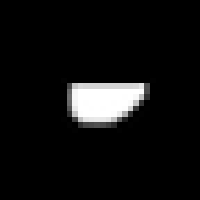

In [49]:
roicat.visualization.display_toggle_image_stack(roinet.ROI_images_rs[:1000], image_size=(200,200))

##### 3. Pass data through network

Pass the data through the network. Expect for large datasets (~40,000 ROIs) that this takes around 15 minutes on CPU or 1 minute on GPU.

In [50]:
roinet.generate_latents();

starting: running data through network


  0%|          | 0/2076 [00:01<?, ?it/s]

completed: running data through network


# UMAP embedding

Reduce the dimensionality of the output of ROInet (~100 dims) to 2 dimensions so that we can visualize it. Feel free to use any settings here that do a good job of clustering your data as you see fit.

In [51]:
umap = UMAP(
    n_neighbors=25,
    n_components=2,
    n_epochs=400,
    verbose=True,
    densmap=False,
)
emb = umap.fit_transform(roinet.latents)

UMAP(n_epochs=400, n_neighbors=25, verbose=True)
Fri Sep 27 01:35:22 2024 Construct fuzzy simplicial set
Fri Sep 27 01:35:22 2024 Finding Nearest Neighbors
Fri Sep 27 01:35:22 2024 Building RP forest with 11 trees
Fri Sep 27 01:35:26 2024 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Fri Sep 27 01:35:38 2024 Finished Nearest Neighbor Search
Fri Sep 27 01:35:41 2024 Construct embedding


Epochs completed:   0%|            0/400 [00:00]

	completed  0  /  400 epochs
	completed  40  /  400 epochs
	completed  80  /  400 epochs
	completed  120  /  400 epochs
	completed  160  /  400 epochs
	completed  200  /  400 epochs
	completed  240  /  400 epochs
	completed  280  /  400 epochs
	completed  320  /  400 epochs
	completed  360  /  400 epochs
Fri Sep 27 01:35:53 2024 Finished embedding


# Draw selection

In order to visualize the kinds of ROIs at each region of the plot, we need to select a subset of points to overlay ROI images onto.

In [52]:
idx_images_overlay = roicat.visualization.get_spread_out_points(
    emb,
    n_ims=min(emb.shape[0], 3000),  ## Select number of overlayed images here
    dist_im_to_point=.8,
     border_frac=0.02,
)

images_overlay = roinet.ROI_images_rs[idx_images_overlay]

In [53]:
images_overlay.shape

(676, 36, 36)

Now we can use an interactive plot (using the holoviews library) to select our region of the scatterplot to circle.\
This plot works as follows:
- Use the **LASSO TOOL** to circle a region on the plot containing the images of ROIs that you'd like to keep/extract/mark.
    - You can circle multiple times, but only the last one will be saved
- The saved indices are saved in a temporary file that can be recovered using the `fn_get_indices` function output below. Just call `fn_get_indices()` and it will return a list of the integer indices.
- If it is difficult to see the images, do the following:
    - adjust the number of images in the above function (`roicat.visualization.get_spread_out_points`) using the `n_ims` argument
    - adjust the overlap of the images in the below function (`roicat.visualization.select_region_scatterPlot`) using the `frac_overlap_allowed` argument

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
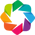

:Overlay
   .Points.I :Points   [x,y]
   .RGB.I    :RGB   [x,y]   (R,G,B,A)

In [54]:
fn_get_indices, layout, path_tempFile = roicat.visualization.select_region_scatterPlot(
    data=emb,
    idx_images_overlay=idx_images_overlay,
    images_overlay=images_overlay[:, 6:30][:,:,6:30],
    size_images_overlay=0.3,
    frac_overlap_allowed=0.9,
    figsize=(800,800),
    alpha_points=1.0,
    size_points=.5,
    color_points='b',
);

Drop the results into easier to use output variables

In [ ]:
# roicat.helpers.export_svg_hv_bokeh(layout, '/home/rich/Desktop/umap_with_labels_dotsOnly.svg')

In [ ]:
n_sessions = len(data.ROI_images)
idx_session_cat = np.concatenate([[ii]*data.ROI_images[ii].shape[0] for ii in range(n_sessions)])
bool_good_cat = roicat.helpers.idx2bool(fn_get_indices(), length=len(idx_session_cat))
preds_good_sessions = [np.int64((bool_good_cat * (idx_session_cat==ii))[idx_session_cat==ii]) for ii in range(data.n_sessions)]

classification_output = {
    'preds': preds_good_sessions,
    'spatialFootprints': data.spatialFootprints,
    'FOV_height': data.FOV_height,
    'FOV_width': data.FOV_width,
    'input_data': data.paths_stat,
    
}

# Visualize outputs

In [ ]:
print(f"Number of 'good' and 'bad' ROIs from each session:")
print([f"good: {p.sum()} / bad: {(p!=1).sum()}" for p in preds_good_sessions])

In [ ]:
FOVs_colored = roicat.visualization.compute_colored_FOV(
    spatialFootprints=data.spatialFootprints,
    FOV_height=data.FOV_height,
    FOV_width=data.FOV_width,
    labels=preds_good_sessions,
    cmap=roicat.helpers.simple_cmap([[1,0,0],[0,1,0]]),
)

roicat.visualization.display_toggle_image_stack(
    FOVs_colored,
    image_size=(FOVs_colored[0].shape[0]*2, FOVs_colored[0].shape[1]*2)
)

# Save results

The results file can be opened using any of the following methods:
1. `roicat.helpers.pickle_load(path)`
2. `np.load(path)`
3. 
```
    import pickle
    with open(path_save, mode='rb') as f:
        test = pickle.load(f)
  ```

In [ ]:
mouse = '719363'

In [ ]:
dir_save = f'/scratch/{mouse}/'
filename_save = mouse

path_save = str(Path(dir_save).resolve() / (filename_save + '.ROICaT.classification_drawn.results' + '.pkl'))
print(f'path_save: {path_save}')

roicat.helpers.pickle_save(classification_output, path_save, mkdir=True)

# Thank you
If you encountered any difficulties, please let us know at the issues page: https://github.com/RichieHakim/ROICaT/issues